In [1]:
from project_heart.lv import LV
import numpy as np
import pyvista as pv
pv.set_jupyter_backend("pythreejs")

import os
from pathlib import Path

from project_heart.enums import *

# Load File

In [28]:
from project_heart.examples import get_lv_typeA
# lv = get_lv_typeA(filepath="C:/Users/igorp/Downloads/0.28_70.00_40.00_LVMYO_HEX8_83648_wr.xplt", statesfile=None)
# lv = get_lv_typeA(filepath="C:/Users/igorp/Downloads/56.15_69.31_25_56.15_69.31_20.07.2022_LVRNN_TYPEA_V4.xplt", statesfile=None)
# lv = get_lv_typeA(filepath="C:/Users/igorp/Downloads/52.85_60.01_70_52.85_60.01_20.07.2022_LVRNN_TYPEA_V4.xplt", statesfile=None)
lv = get_lv_typeA(filepath="C:/Users/igorp/Downloads/65.55_65.55_1_65.55_65.55_02.08.2022.1_LVRNN_TYPEA_V4.xplt", statesfile=None)


INFO:LV_RegionIdentifier.identify_regions_typeA:Identifying regions from 'type A' geometry.
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(endo_base): 329
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(epi_base): 369


In [29]:
lv.plot("surface", 
        scalars=LV_MESH_DATA.SURFS_DETAILED,
        categorical=True,
        )

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

# Extract Metrics

## Extract geometrics

In [31]:
df = lv.extract_geometrics({
        "volume":{},
        "apex_base_over_timesteps": {
            "apex_spks": {"spk_name":"apex", "spk_group":"endo", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_group":"endo", "spk_collection":"LA"},
            },
        # "longitudinal_distance": {
        #     "apex_spks": {"spk_name":"apex", "spk_collection":"LA"},
        #     "base_spks": {"spk_name":"base", "spk_collection":"LA"},
        #     "approach":"centroid", 
        #     "use_axis_aligment":False,
        #     "reduce_by":{"group"}
        #     },
        # "radial_distance": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "approach":"moving_vector",
        #     "reduce_by":{"group", "name", "group_name"},
        #     },
        # "radial_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "approach":"moving_centers",
        #     "reduce_by":{"group", "name", "group_name"},
        #     },
        # "wall_thickness": {
        #     "endo_spks": {"spk_group":"endo", "spk_collection":"circ-6"},
        #     "epi_spks": {"spk_group":"epi", "spk_collection":"circ-6"},
        #     "approach":"radial_distance",
        #     "reduce_by":{"name"},
        #     },
        # "longitudinal_length": {
        #     "spks": {"spk_collection":"long-6"},
        #     "approach":"k_ids",
        #     "reduce_by":{"subset"},
        #     "merge_subset":{
        #             5: 0, 
        #             4: 1, 
        #             3: 2
        #         },
        #     },
        "global_longitudinal_length": {
            "spks": {"spk_collection":"long-1"},
            "approach":"k_ids",
            "reduce_by":{"group", "group_name"},
            },
        # "circumferential_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group"},
        #     },
        "global_circumferential_length": {
            "spks": {"spk_collection":"circ-1"},
            "reduce_by":{"group", "group_name"},
            },
        # "angle_rotation": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group", "name"},
        #     }
        }
    )

INFO:LV:Computing apex_base_over_timesteps.
INFO:LV.BaseMetricsComputations.compute_base_apex_ref_over_timesteps:Computing apex and base virtual nodes over timesteps
INFO:LV:Extracting volume.
INFO:LV:Extracting global_longitudinal_length.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.GLOBAL_LONGITUDINAL_LENGTH'
INFO:LV:Extracting global_circumferential_length.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.GLOBAL_CIRCUMFERENTIAL_LENGTH'


## Compute strain values

In [32]:
idx_ref = lv.states.get_timestep_index(0.1) # initial timestep after pre-loading

In [33]:
cl = df["global_circumferential_length_endo"].values[idx_ref:]
cst = ((cl - cl[0]) / cl[0]) * 100

In [36]:
sl = df["global_longitudinal_length_endo"].values[idx_ref:]
lst = ((sl - sl[0]) / sl[0]) * 100

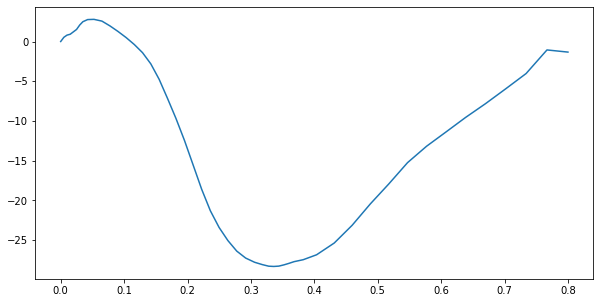

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(lv.states.timesteps[10:]-0.1, cst)

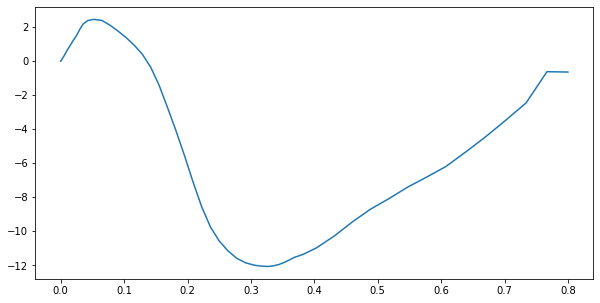

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(lv.states.timesteps[10:]-0.1, lst)

# Extract metrics from reference file (from other papers)

In [38]:
import pandas as pd

In [39]:
xls = pd.ExcelFile("C:/Users/igorp/OneDrive - University of South Florida/Igor/Documents/References (organized)/Clinical Metrics/extracted_cms.xlsx") #pd.read_excel("./extracted_cms.xlsx")
cms = {}
for sheet_name in xls.sheet_names:
    cms[sheet_name] = xls.parse(sheet_name)

In [40]:
ts = lv.states.timesteps[10:]-0.1
def scale_data(key):
  ts_old  = cms[key]["time"].values/1000
  ts_interp = np.interp(ts_old, 
                        (ts_old.min(), ts_old.max()), 
                        (ts.min(), ts.max())) 
  try:
    val = cms[key][key.lower()].values
  except:
    val = cms[key][key].values
  return ts_interp, np.interp(ts, ts_interp, val)

In [41]:
ts_, lst_ref = scale_data("LST")
_, cst_ref = scale_data("CST")

# Extract Stress/Strain data (for plotting)

In [42]:
spks = lv.get_speckles(spk_collection="circ-1")
lv.compute_stress(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)
lv.compute_strain(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)

INFO:LV.BaseMetricsComputations:Computing metric 'effective_stress' with 'effective' set to 'True'
INFO:LV.BaseMetricsComputations:Computing metric 'effective_Lagrange strain' with 'effective' set to 'True'


In [43]:
df1, infos1 = lv.get_metric_as_df("effective_stress")
df2, infos2 = lv.get_metric_as_df("effective_Lagrange strain")

df = pd.concat((df, df1, *infos1.values(), df2, *infos2.values()), axis=1)
df = df.loc[:,~df.columns.duplicated()].copy()

# Modify DF

In [44]:
df = df[df["timesteps"] >= 0.1]
df["timesteps"] -= 0.1

df.reset_index(inplace=True)
df.drop("index", inplace=True, axis=1)

df["volume"] /= 1000

# Read Record file (inputs for simulation)

In [45]:
record = pd.read_feather("C:/Users/igorp/Downloads/1_65.55_65.55_02.08.2022.1_LVRNN_TYPEA_V4.ftr")

record.drop("timesteps", axis=1, inplace=True)

In [46]:
record.head()

,P_n,V_n,P_s,V_s,gw_est,gw,endo,epi,endo_est,epi_est,cm_LS,cm_RS,cm_WT,cm_SL,cm_SC,cm_EF,cd_EF
0,0.092171,0.999301,1.474734,94.933640,0.060858,0.060858,65.54567,-65.545059,65.54567,-65.545059,0.1,0.3,0.3,0.1256,0.3076,0.50679,49.551289
1,0.127715,0.999661,2.043444,94.967758,0.068031,0.068031,65.54567,-65.545059,65.54567,-65.545059,0.1,0.3,0.3,0.1256,0.3076,0.50679,49.551289
2,0.180530,0.999471,2.888475,94.949760,0.078629,0.078629,65.54567,-65.545059,65.54567,-65.545059,0.1,0.3,0.3,0.1256,0.3076,0.50679,49.551289
3,0.232736,0.999471,3.723771,94.949760,0.085855,0.085855,65.54567,-65.545059,65.54567,-65.545059,0.1,0.3,0.3,0.1256,0.3076,0.50679,49.551289
4,0.284942,0.999471,4.559066,94.949760,0.091088,0.091088,65.54567,-65.545059,65.54567,-65.545059,0.1,0.3,0.3,0.1256,0.3076,0.50679,49.551289


In [47]:
df = pd.concat((df, record), axis=1)

# Add data to DF

In [48]:
df["CST"] = cst
df["LST"] = lst
df["CST_REF"] = cst_ref
df["LST_REF"] = lst_ref

In [49]:
cst

array([  0.        ,   0.53292739,   0.80789206,   0.91625368,
         1.2185576 ,   1.51813288,   2.07776484,   2.49606301,
         2.76407645,   2.79215349,   2.57104749,   1.96783235,
         1.2676658 ,   0.49856882,  -0.37647581,  -1.40177279,
        -2.81102739,  -4.75531818,  -7.16754252,  -9.68934698,
       -12.46020657, -15.5160213 , -18.60397909, -21.30715391,
       -23.41057034, -25.05941338, -26.38740341, -27.26458925,
       -27.79619955, -28.0900321 , -28.28928371, -28.32197442,
       -28.28041228, -28.1234766 , -27.93158528, -27.72004275,
       -27.47296499, -26.85248439, -25.37286649, -23.13977187,
       -20.44641381, -17.93415829, -15.25289778, -13.1874878 ,
       -11.39952371,  -9.56822744,  -7.83429975,  -5.96346331,
        -4.02778077,  -1.05958037,  -1.3304193 ])

In [51]:
df.to_csv("comp_results.csv")

<AxesSubplot:xlabel='timesteps'>

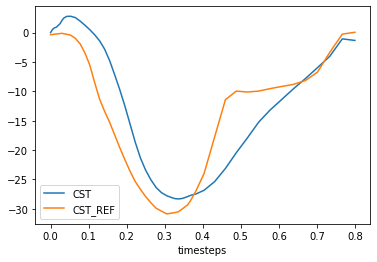

In [50]:
df.plot(x="timesteps", y=["CST", "CST_REF"])